In [1342]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [1343]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [1344]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [1345]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:01<00:00, 50.39it/s]


Rosacea


100%|██████████| 100/100 [00:02<00:00, 45.48it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [1346]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [ ]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [ ]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    kernel = np.zeros((size, size), dtype=np.float64)

    for i in range(size):
        for j in range(size):
            x = ax[j]  
            y = ax[i]  
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2. * sigma**2))

    return kernel / np.sum(kernel)

def konvolusi(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    output = np.zeros_like(image, dtype=np.float64)

    for i in range(img_h):
        for j in range(img_w):
            region = padded_image[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

def gaussian_blur(image: np.ndarray, kernel_size: int = 3, sigma: float = 0.0) -> np.ndarray:
    if sigma == 0.0:
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8

    kernel = gaussian_kernel(kernel_size, sigma)
    blurred = konvolusi(image, kernel)
    return blurred


In [1350]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [1351]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [1352]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [1353]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [1354]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    blurred = gaussian_blur(gray_img, kernel_size=10, sigma=0)
    citra_sobel = sobel(blurred)
    citra_opening = opening(citra_sobel)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)

Exception ignored in: <function tqdm.__del__ at 0x000001F0E65ACEE0>
Traceback (most recent call last):
  File "d:\Anaconda\envs\PCD\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "d:\Anaconda\envs\PCD\lib\site-packages\tqdm\std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


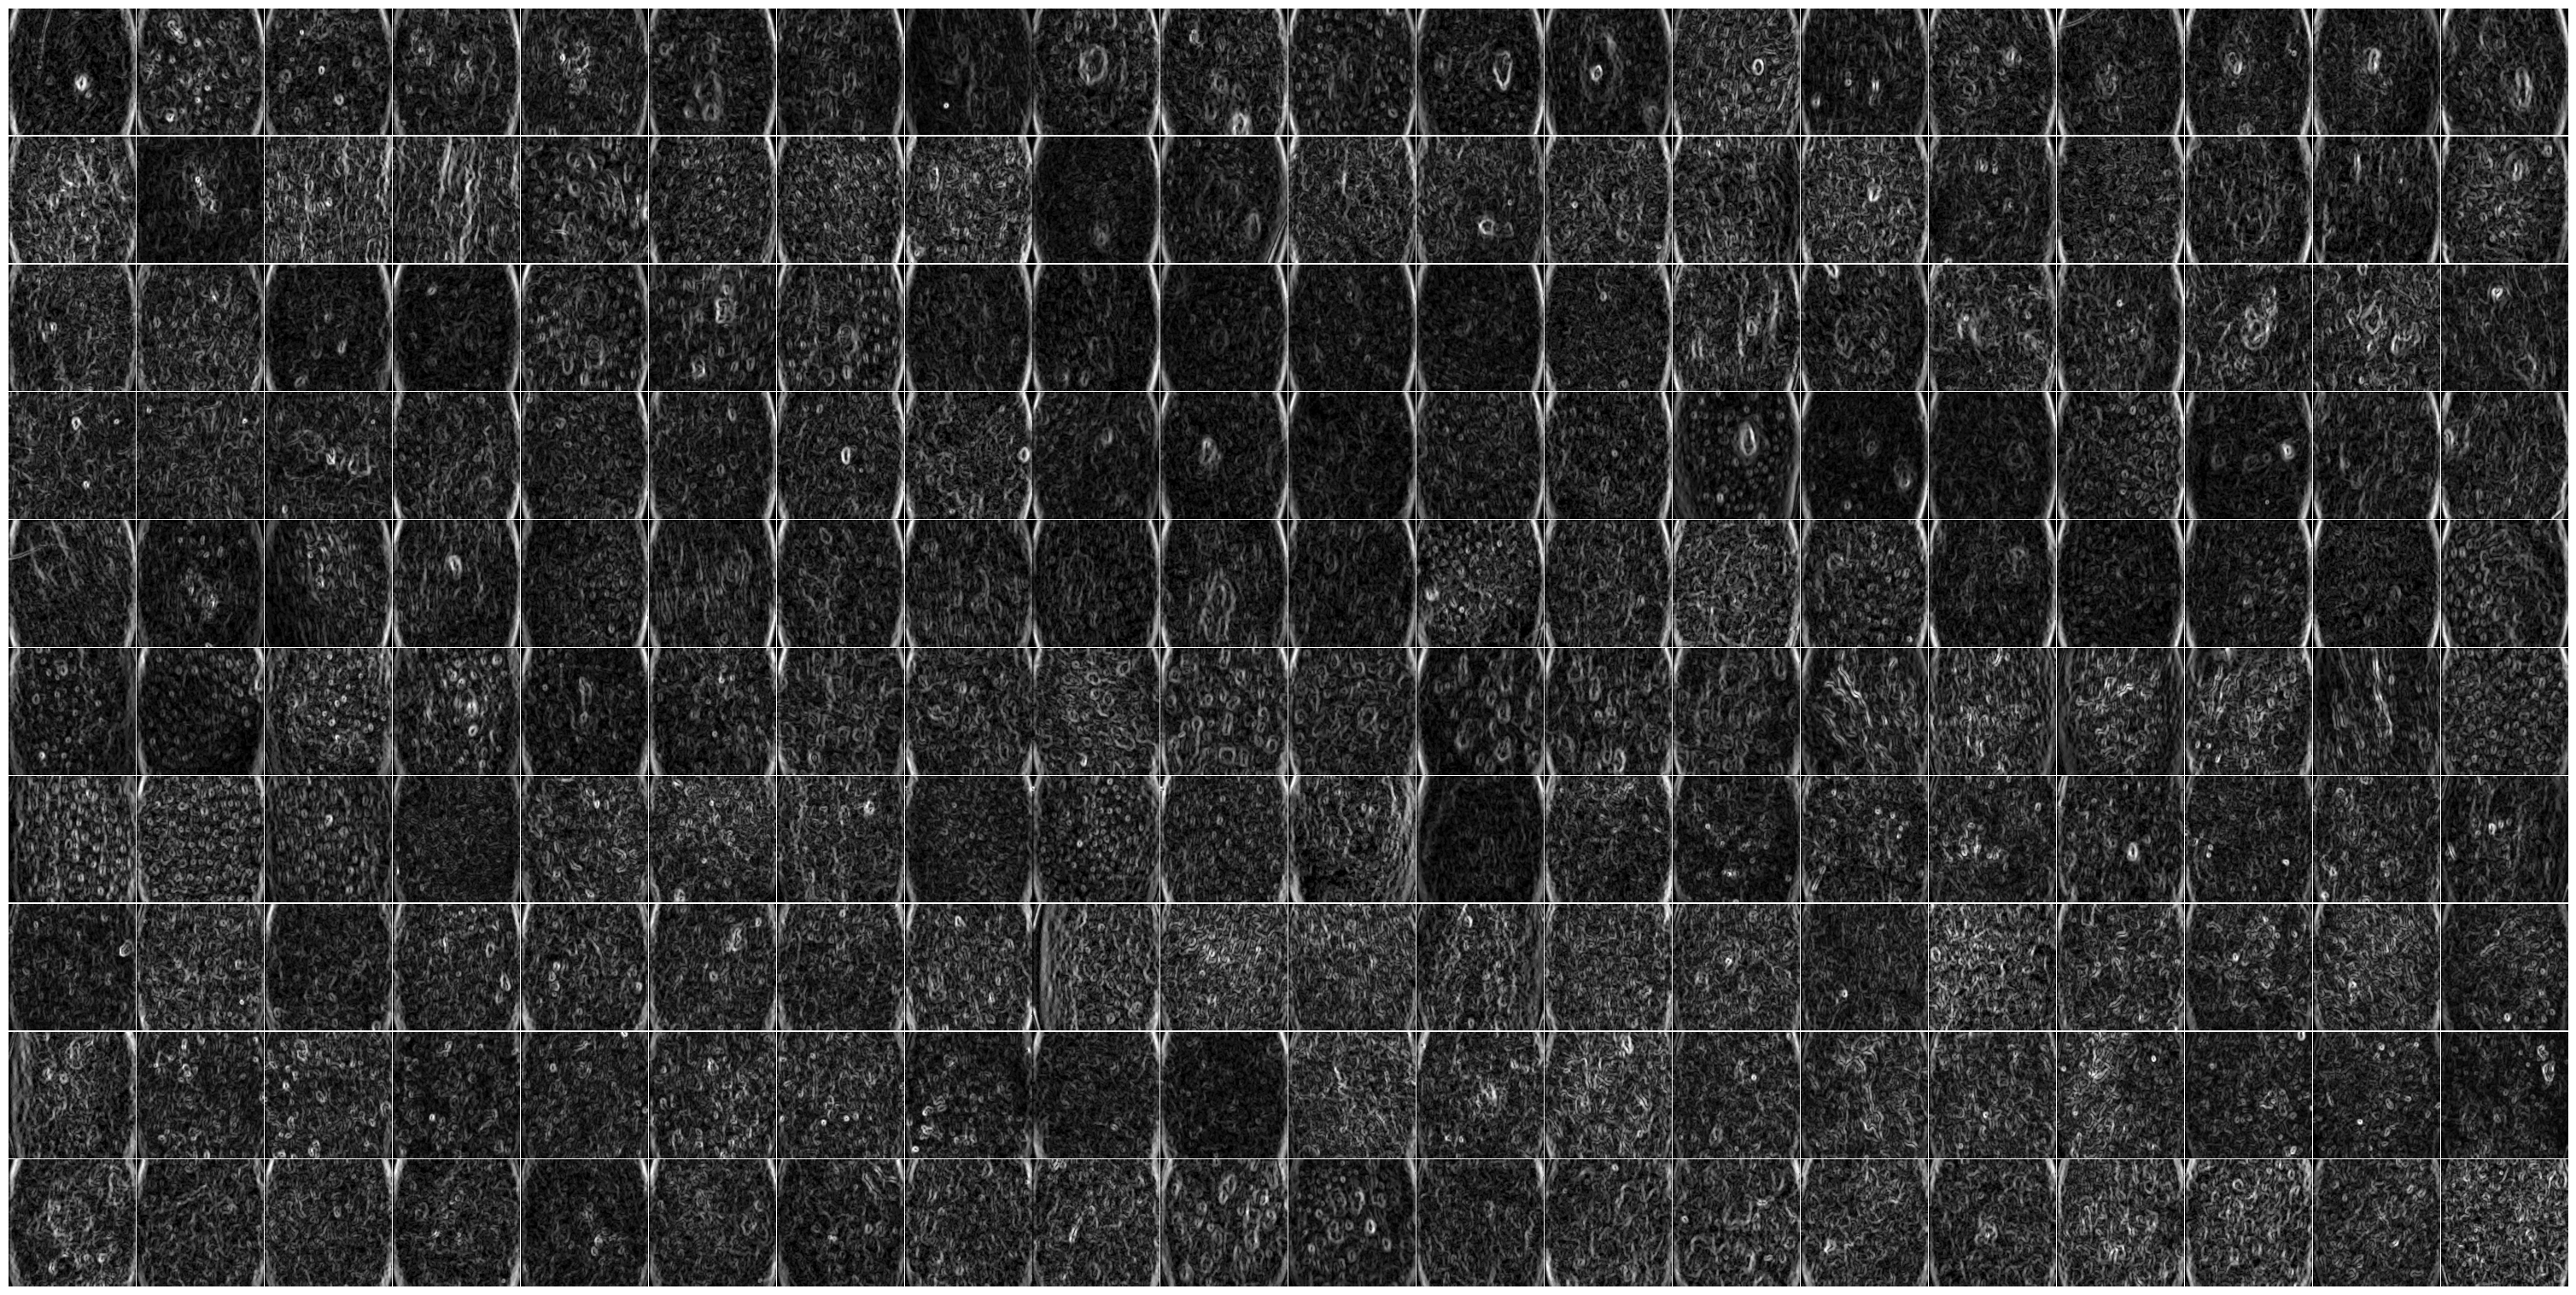

In [1355]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [1356]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [1357]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [1358]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [1359]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [1360]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [1361]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [1362]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [1363]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [1364]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [1365]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [1366]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [1367]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [1368]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [1369]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [1370]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [1371]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [1372]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [1373]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [1374]:
print(df.describe())  # Lihat ringkasan statistik fitur

        Contrast0  Contrast45  Contrast90  Contrast135  Homogeneity0  \
count  200.000000  200.000000  200.000000   200.000000    200.000000   
mean   267.561328  364.007785  171.254622   366.554411      0.519010   
std    127.339888  171.454354   83.236933   173.933023      0.015879   
min     50.053263   75.034664   38.388205    71.518016      0.480952   
25%    174.566425  233.786555  110.932227   242.090711      0.508400   
50%    244.291169  335.418170  157.742310   341.265613      0.518519   
75%    327.112600  442.815210  205.679232   438.292618      0.528201   
max    778.771967  976.411365  415.529963  1000.058577      0.561899   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     200.000000     200.000000      200.000000      200.000000   
mean        0.322876       0.520359        0.323114        8.451417   
std         0.020705       0.018708        0.020649        2.186416   
min         0.274187       0.469865        0.274260        3.614537

<h1>CSV</h1>

In [1375]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_5.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_5.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  169.916590  238.875110   87.602221   
1    102_2.jpg  Acne Vulgaris  206.408257  261.627882  123.019807   
2    103_2.jpg  Acne Vulgaris  170.008502  239.087382  101.348713   
3    106_1.jpg  Acne Vulgaris  182.843949  234.515110   85.574847   
4    106_7.jpg  Acne Vulgaris  189.423560  253.280907   77.422595   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  225.603171  305.448181  126.882123   
196  118_3.jpg        Rosacea  402.190640  504.956355  184.720435   
197  118_4.jpg        Rosacea  400.314507  565.037770  208.043413   
198  119_1.jpg        Rosacea  236.042142  364.920477  155.163159   
199  119_2.jpg        Rosacea  512.746063  723.772026  311.208471   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     203.639862      0.545540       0.399940       0.588075        0.413792   
1     318.799723      0.440094       0.292389       0.480071        0.289582   
2     233.941023      0.505590       0.354241       0.543592        0.360337   
3     238.576686      0.478381       0.331679       0.527815        0.332454   
4     221.422238      0.450637       0.300080       0.501615        0.306298   
..           ...           ...            ...            ...             ...   
195   312.107328      0.481469       0.328399       0.514033        0.324027   
196   535.160830      0.434133       0.274629       0.469453        0.275257   
197   504.839231      0.470602       0.314958       0.508824        0.320898   
198   303.416271      0.462540       0.292786       0.477776        0.300370   
199   707.116248      0.474892       0.305818       0.489984        0.306985   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.052984  0.034529  0.215355  0.181735  0.230182   0.185819   
1    ...  0.020528  0.011374  0.131100  0.108554  0.143277   0.106647   
2    ...  0.038122  0.023385  0.182365  0.150978  0.195249   0.152921   
3    ...  0.030636  0.017584  0.159410  0.132741  0.175032   0.132603   
4    ...  0.025563  0.013921  0.141385  0.116106  0.159884   0.117987   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.031767  0.018424  0.166099  0.137132  0.178232   0.135736   
196  ...  0.019706  0.010487  0.127974  0.102777  0.140380   0.102405   
197  ...  0.029697  0.017293  0.158087  0.129500  0.172327   0.131503   
198  ...  0.023884  0.014141  0.147406  0.116392  0.154545   0.118916   
199  ...  0.027048  0.015601  0.157231  0.125041  0.164464   0.124906   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.942943       0.919686       0.970664        0.931532  
1        0.925074       0.905018       0.955444        0.884263  
2        0.915497       0.881001       0.949581        0.883562  
3        0.923489       0.901783       0.964483        0.900081  
4        0.890367       0.853296       0.955274        0.871749  
..            ...            ...            ...             ...  
195      0.901709       0.866663       0.944703        0.863754  
196      0.872593       0.839878       0.941516        0.830301  
197      0.886106       0.838924       0.940726        0.856084  
198      0.868500       0.796412       0.913553        0.830723  
199      0.841711       0.776507       0.903998        0.781648  

[200 rows x 30 columns]

<Axes: >

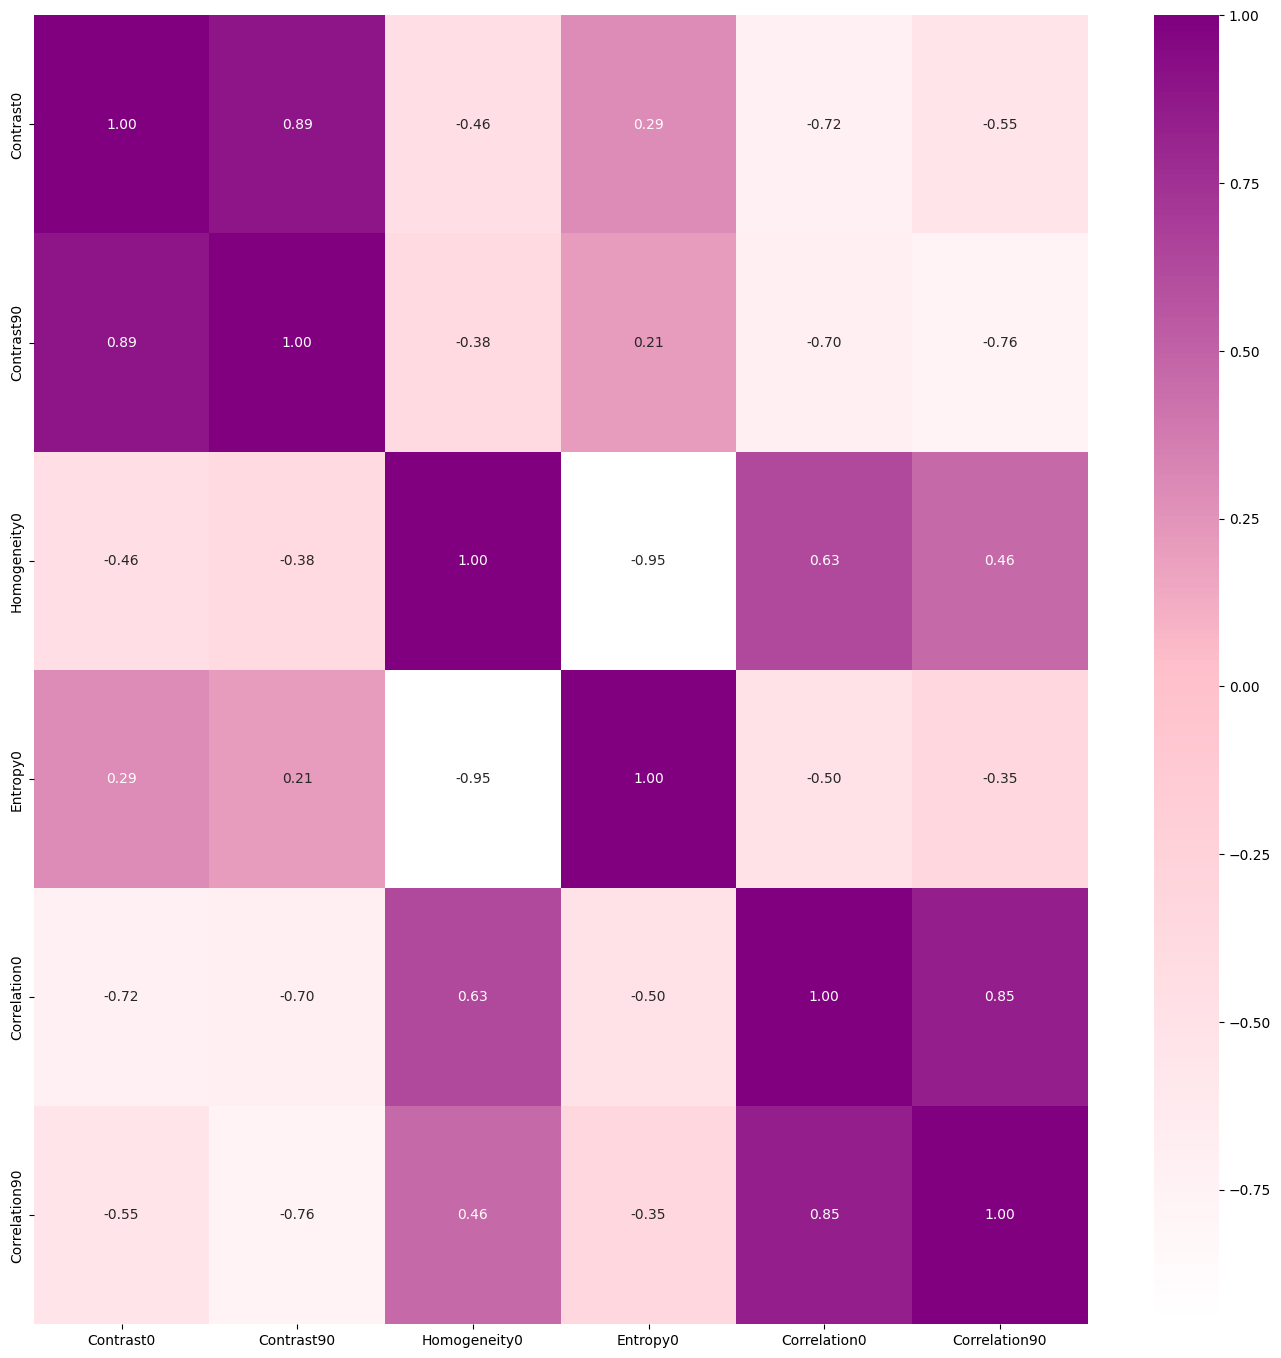

In [1376]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [1377]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [1378]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [1414]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=14, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [1415]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------RANDOM FOREST------")
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------RANDOM FOREST------
------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.97      0.99      0.98        69
      Rosacea       0.99      0.97      0.98        71

     accuracy                           0.98       140
    macro avg       0.98      0.98      0.98       140
 weighted avg       0.98      0.98      0.98       140

[[68  1]
 [ 2 69]]
Accuracy: 0.9785714285714285

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.85      0.90      0.88        31
      Rosacea       0.89      0.83      0.86        29

     accuracy                           0.87        60
    macro avg       0.87      0.87      0.87        60
 weighted avg       0.87      0.87      0.87        60

[[28  3]
 [ 5 24]]
Accuracy: 0.8666666666666667


In [1400]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------SVM------")
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

------SVM------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.74      0.77        69
      Rosacea       0.76      0.82      0.79        71

     accuracy                           0.78       140
    macro avg       0.78      0.78      0.78       140
 weighted avg       0.78      0.78      0.78       140

[[51 18]
 [13 58]]
Accuracy: 0.7785714285714286

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.90      0.84      0.87        31
      Rosacea       0.84      0.90      0.87        29

     accuracy                           0.87        60
    macro avg       0.87      0.87      0.87        60
 weighted avg       0.87      0.87      0.87        60

[[26  5]
 [ 3 26]]
Accuracy: 0.8666666666666667


In [1401]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------KNN------")
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

------KNN------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.81      0.78        69
      Rosacea       0.80      0.75      0.77        71

     accuracy                           0.78       140
    macro avg       0.78      0.78      0.78       140
 weighted avg       0.78      0.78      0.78       140

[[56 13]
 [18 53]]
Accuracy: 0.7785714285714286

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.81      0.84      0.83        31
      Rosacea       0.82      0.79      0.81        29

     accuracy                           0.82        60
    macro avg       0.82      0.82      0.82        60
 weighted avg       0.82      0.82      0.82        60

[[26  5]
 [ 6 23]]
Accuracy: 0.8166666666666667


In [1383]:
print("\n------Train Set RF------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set SVM------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set KNN------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)


------Train Set RF------
               precision    recall  f1-score   support

Acne Vulgaris       0.95      0.91      0.93        69
      Rosacea       0.92      0.96      0.94        71

     accuracy                           0.94       140
    macro avg       0.94      0.94      0.94       140
 weighted avg       0.94      0.94      0.94       140

[[63  6]
 [ 3 68]]
Accuracy: 0.9357142857142857

------Train Set SVM------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.74      0.77        69
      Rosacea       0.76      0.82      0.79        71

     accuracy                           0.78       140
    macro avg       0.78      0.78      0.78       140
 weighted avg       0.78      0.78      0.78       140

[[51 18]
 [13 58]]
Accuracy: 0.7785714285714286

------Train Set KNN------
               precision    recall  f1-score   support

Acne Vulgaris       0.67      0.81      0.74        69
      Rosacea       0.77      0.62      0.69   

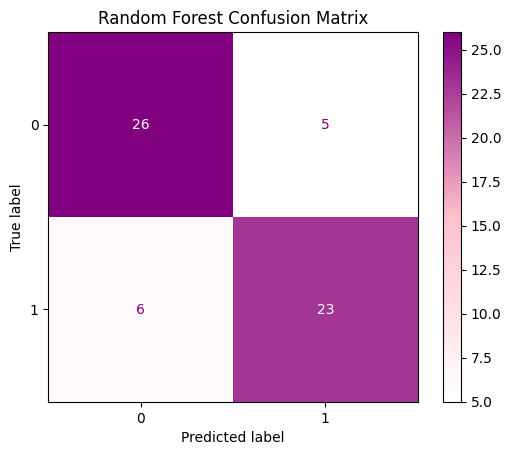

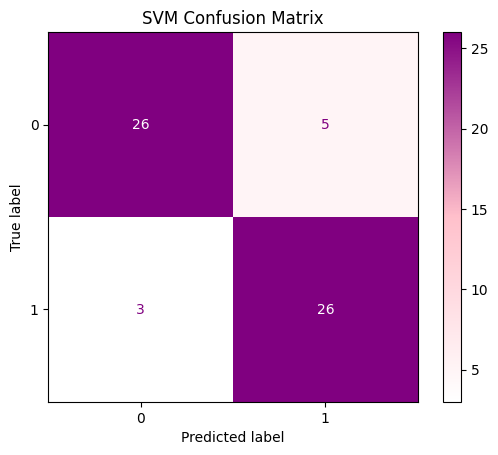

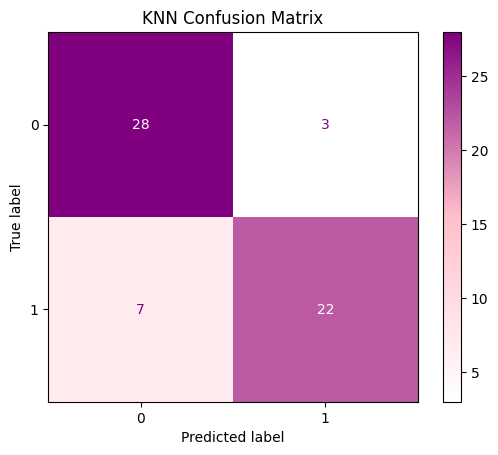

In [1384]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")